# Sujet 1 : Concentration de CO2 dans l'atmosphère depuis 1958

La concentration en CO2 atmosphérique est une donnée majeure dans un contexte de changement climatique. Celle-ci est mesurée à l'observatoire de Mauna Loa, depuis 1958, à l'initiative de [Charles David Keeling](https://en.wikipedia.org/wiki/Charles_David_Keeling).

L'analyse de la chronique de la concentration en CO2 atmosphérique a pour objectif de mettre en évidence:
1. l'évolution à long terme du signal
2. la saisonnalité du signal 

In [1]:
#import des packages
%matplotlib inline
import os
import urllib.request
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

Les mesures de concentration en CO2 atmosphérique sont disponibles d' l'url suivante: https://scrippsco2.ucsd.edu/data/atmospheric_co2/primary_mlo_co2_record.html

Les données on été mesurées à Mauna Loa.
![localisation du point de mesure](https://scrippsco2.ucsd.edu/assets/images/mlo_station_map.png "Mauna Loa Observatory, Hawaii")

## Importation des données
Les données sont téléchargées au format CSV. Ce fichier comporte une notice de 43 lignes qui seront ignorées lors de l'import. Il est structuré en deux colonnes, la date au format "yyyy-mm-dd" et la concentrations en CO2 en micro-mol CO2 per mol (ppm).
Le dataset a été téléchargé le 26/03/2020 et couvre la période de 29-03/1958 au 01-02-2020.

In [2]:
data_url = "https://scrippsco2.ucsd.edu/assets/data/atmospheric/stations/in_situ_co2/weekly/weekly_in_situ_co2_mlo.csv"
data_file = "scripps-week-CO2.csv"

if not os.path.exists(data_file):
    urllib.request.urlretrieve(data_url, data_file)
    
raw_data = pd.read_csv(data_file, skiprows=44, header=0, names=['dates' , 'CO2'])
raw_data.iloc[np.r_[0:5, -5:0]]

dates     CO2
0     1958-04-05  317.31
1     1958-04-12  317.69
2     1958-04-19  317.58
3     1958-04-26  316.48
4     1958-05-03  316.95
3150  2019-12-28  412.59
3151  2020-01-04  413.19
3152  2020-01-11  413.39
3153  2020-01-25  413.36
3154  2020-02-01  413.99

Conversion des dates au format datetime


In [3]:
date_list = [datetime.strptime(date, '%Y-%m-%d') for date in raw_data['dates']]

data = pd.DataFrame()
data['dates'] = date_list
data['CO2'] = raw_data['CO2']

Appercu des données

CO2
count  3155.000000
mean    355.395702
std      28.218412
min     313.040000
25%     329.885000
50%     352.880000
75%     378.090000
max     415.080000

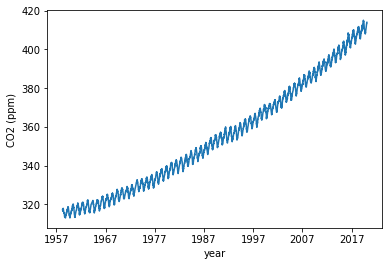

In [4]:
plt.plot(data['dates'], data['CO2']);
plt.xlabel('year');
plt.ylabel('CO2 (ppm)');

data.describe()

## Tendance long terme
La concentration en CO2 entre 1957 et 2017 présente une cyclicité annuelle superposée à une tendance à long terme. La tendance à long terme peut être estimée à l'aide d'une moyenne glissante. La [moyenne glissante](https://fr.wikipedia.org/wiki/Moyenne_mobile) est calculée pour chaque temps t en faisant la moyenne des n points autour tu temps t:
$$ 
MoyenneGlissante(t) = \frac{1}{n}  \sum_{i=t-\frac{n}{2}}^{t+\frac{n}{2}} data(i)
$$
Cette opération a pour objectif de lisser les cyclicités annuelles et donc d'isoler la tendance à long term.

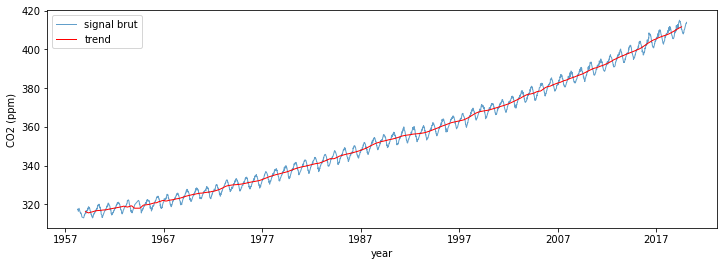

In [14]:
n = 52 #taille de la fenêtre de moyenne glissante fixée à 1 an (52 semaines)

data['trend'] = data['CO2'].rolling(n, center=True, min_periods=52).mean()

plt.figure(figsize=(12,4))
plt.plot(data['dates'], data['CO2'], label='signal brut', alpha=0.7, linewidth=1);
plt.plot(data['dates'], data['trend'], label='trend', linewidth=1, color='r');
plt.xlabel('year');
plt.ylabel('CO2 (ppm)');
plt.legend();

## Saisonnalité
La tendance long terme étant identifiée, on peut la soustraire au signal brut pour isoler la composante saisonnière. On obtient la variation annuelle autours de la tendans long terme.
$$ Saisonnalité(t) = data(t) - MoyenneGlissante(t) $$

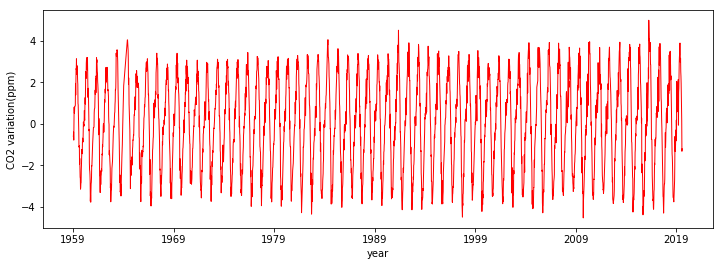

In [15]:
data['season'] = data['CO2'] - data['trend']
plt.figure(figsize=(12,4))
plt.plot(data['dates'], data['season'], label='saisonnalité', linewidth=1, color='r');
plt.xlabel('year');
plt.ylabel('CO2 variation(ppm)');

La saisonnalité peut être représenter en fonction du jour de l'année. On peut alors identifier les périodes de maximum annuel (jour 100 à 150, de mars à mai) et minimum annuel (jour 270, septembre).

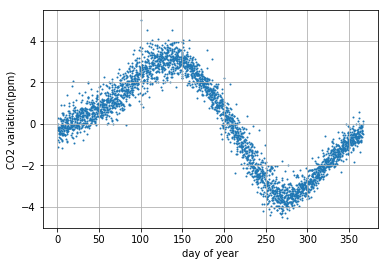

In [16]:
doy_list = [date.timetuple().tm_yday for date in data['dates']]
data['DOY'] = doy_list

plt.scatter(data['DOY'], data['season'], s=1);
plt.xlabel('day of year');
plt.ylabel('CO2 variation(ppm)');
plt.grid()

## Modélisation du CO2
La modélisation de la concentration en CO2 atmosphérique repose sur deux composantes :
- la tendance long terme qui peut être modélisée par une fonction polynomiale
- la saisonnalité annuelle qui peut être modélisée par une fonction période

La fonction polynomial adoptée semble a priori d'odre 2 ($ y(t) = a.t^2 + b.t + c$).
La fonction période peut être ajustée par un fonction du type $ \alpha cos(\frac{2\pi t}{365}) + \beta sin(\frac{2\pi t}{365}) $.

Ainsi, la concentration simulée (notée CO2*) est égale à:
$$ 
CO2^*(t) = a.t^2 + b.t + c + \alpha cos(\frac{2\pi t}{365}) + \beta sin(\frac{2\pi t}{365})
$$

L'ajustement des paramètres (a, b, c, $\alpha$ et $\beta$) peut être effectué par la [méthode des moindres carrés](https://fr.wikipedia.org/wiki/M%C3%A9thode_des_moindres_carr%C3%A9s).

La variable t doit être numérique pour cete modélisation, les dates sont converties en dates  *proleptic Gregorian ordinal*.

In [17]:
def Simulation_co2(t,a,b,c,alpha,beta):
    co2sim = a*t**2 + b*t + c + alpha * np.cos(2*np.pi*t/365) + beta*np.sin(2*np.pi*t/365)
    return co2sim

date_num = [datetime.toordinal(date) for date in data['dates']]
data['date_num'] = date_num

In [18]:
import scipy.optimize as optimization

xdata = np.array(data['date_num'])
ydata = np.array(data['CO2'])

# Initial guess of the parameters
x0 = np.zeros(5)

#least squares
parameters = optimization.curve_fit(Simulation_co2, xdata, ydata, x0)[0]
print("Les paramètres du modèle sont:" )
print('a :', parameters[0]),
print('b :', parameters[1])
print('c :', parameters[2])
print('alpha :', parameters[3])
print('beta :', parameters[4])

Les paramètres du modèle sont:
a : 9.750717467133496e-08
b : -0.1373113380069189
c : 48644.37669447582
alpha : -1.9895707307020227
beta : -2.0474089148616845


Les composantes lente (Trend\*) et saisonnière (Season\*) du modèle sont les suivantes :
$$ 
Trend^*(t) = 9,75.10^{-8} t^2 - -0.137 t + 48644.376 
$$
$$
Season^*(t) =  -1.990 cos(\frac{2\pi t}{365}) -2.047 sin(\frac{2\pi t}{365})
$$

### Simulation du CO2 en fonction du temps d'après le modèle construit sur la base de la tendance long terme et de la fonction période.

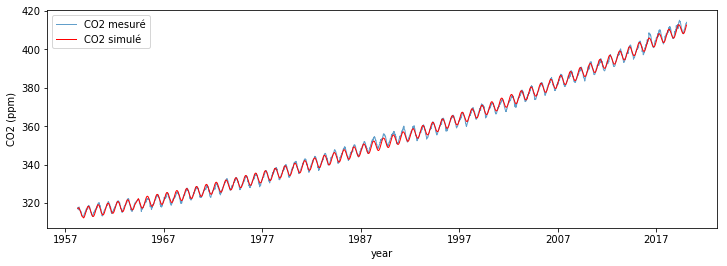

In [20]:
CO2sim = Simulation_co2(xdata, 
                        parameters[0],
                        parameters[1],
                        parameters[2],
                        parameters[3],
                        parameters[4])
data['CO2*'] = CO2sim

plt.figure(figsize=(12,4))
plt.plot(data['dates'], data['CO2'], label='CO2 mesuré', linewidth=1, alpha=0.7);
plt.plot(data['dates'], data['CO2*'], label='CO2 simulé', linewidth=1, color='r');
plt.xlabel('year');
plt.ylabel('CO2 (ppm)');
plt.legend();

Le modèle reproduit bien le signal observé, on peut tenter une extrapolation jusque 2025.

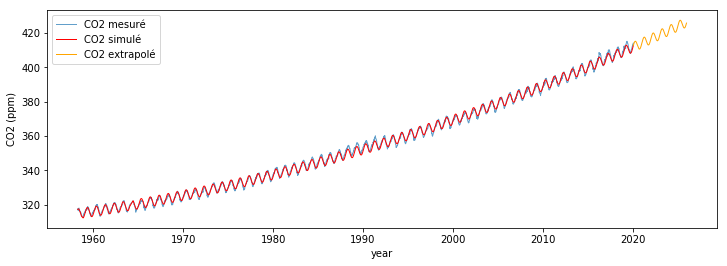

In [22]:
#dates numeriques de la période extrapolée
end_date_str = '2026-01-01'
extra_end = datetime.toordinal(datetime.strptime(end_date_str, '%Y-%m-%d'))
dates_num_extra = np.arange(xdata[-1], extra_end)

extrapolation = Simulation_co2(dates_num_extra, 
                                parameters[0],
                                parameters[1],
                                parameters[2],
                                parameters[3],
                                parameters[4])

#dates de la période extrapolée
dates_extra = [datetime.fromordinal(date) for date in dates_num_extra]

#plot de l'observation versus simulation
plt.figure(figsize=(12,4))
plt.plot(data['dates'], data['CO2'], label='CO2 mesuré', linewidth=1, alpha=0.7);
plt.plot(data['dates'], data['CO2*'], label='CO2 simulé', linewidth=1, color='r');
plt.xlabel('year');
plt.ylabel('CO2 (ppm)');

#plot de l'extrapolation
plt.plot(dates_extra, extrapolation, label='CO2 extrapolé', linewidth=1, color='orange');
plt.legend();